# British Airways Virtual Internship

First I'll install all the necessary libraries

In [1]:
pip install requests beautifulsoup4 pandas

Note: you may need to restart the kernel to use updated packages.


## Scarping the website for 400 British Airways Reviews 

In [12]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Create the "data" folder if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# List of URLs for the four pages
urls = [
    "https://www.airlinequality.com/airline-reviews/british-airways/page/1/?sortby=post_date%3ADesc&pagesize=100",
    "https://www.airlinequality.com/airline-reviews/british-airways/page/2/?sortby=post_date%3ADesc&pagesize=100",
    "https://www.airlinequality.com/airline-reviews/british-airways/page/3/?sortby=post_date%3ADesc&pagesize=100",
    "https://www.airlinequality.com/airline-reviews/british-airways/page/4/?sortby=post_date%3ADesc&pagesize=100"
]

# Function to extract ratings for a category
def extract_rating(review, category):
    rating_container = review.find('td', class_=f'review-rating-header {category}')
    if rating_container:
        stars = rating_container.find_next_sibling('td').find_all('span', class_='star fill')
        return len(stars)
    return "Not Rated"

# Collect reviews from all pages
reviews = []
for url in urls:
    print(f"Scraping URL: {url}")
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract review details
    review_articles = soup.find_all('article', class_='comp_media-review-rated')  # Adjusted to target the correct review articles

    for review in review_articles:
        try:
            # Extract the review rating
            rating = review.find('span', itemprop='ratingValue').text.strip() if review.find('span', itemprop='ratingValue') else "No Rating"
            
            # Extract the title
            title = review.find('h2', class_='text_header').text.strip() if review.find('h2', class_='text_header') else "No Title"
            
            # Extract the author name
            author = review.find('span', itemprop='name').text.strip() if review.find('span', itemprop='name') else "No Author"
            
            # Extract the review date
            date = review.find('time')['datetime'] if review.find('time') else "No Date"
            
            # Extract the content
            content = review.find('div', class_='text_content').text.strip() if review.find('div', class_='text_content') else "No Content"
            
            # Extract additional flight-related information
            aircraft = review.find('td', class_='review-value').text.strip() if review.find('td', class_='review-value') else "No Aircraft Info"

            # Extract specific ratings (e.g., seat comfort, cabin staff service, etc.)
            ratings = {
                'seat_comfort': extract_rating(review, 'seat_comfort'),
                'cabin_staff_service': extract_rating(review, 'cabin_staff_service'),
                'food_and_beverages': extract_rating(review, 'food_and_beverages'),
                'inflight_entertainment': extract_rating(review, 'inflight_entertainment'),
                'ground_service': extract_rating(review, 'ground_service'),
                'wifi_and_connectivity': extract_rating(review, 'wifi_and_connectivity'),
                'value_for_money': extract_rating(review, 'value_for_money')
            }

            # Extract the recommendation (if available)
            recommended = review.find('td', class_='review-value rating-no').text.strip() if review.find('td', class_='review-value rating-no') else "Yes"
            
            # Append the extracted information to the reviews list
            reviews.append({
                'rating': rating,
                'title': title,
                'author': author,
                'date': date,
                'content': content,
                'aircraft': aircraft,
                'seat_comfort': ratings['seat_comfort'],
                'cabin_staff_service': ratings['cabin_staff_service'],
                'food_and_beverages': ratings['food_and_beverages'],
                'inflight_entertainment': ratings['inflight_entertainment'],
                'ground_service': ratings['ground_service'],
                'wifi_and_connectivity': ratings['wifi_and_connectivity'],
                'value_for_money': ratings['value_for_money'],
                'recommended': recommended
            })
        except Exception as e:
            print(f"Error extracting review: {e}")

# Convert reviews to a DataFrame for analysis
if reviews:
    df = pd.DataFrame(reviews)
    df.to_csv('data/british_airways_reviews_400.csv', index=False)
    print("Reviews scraped and saved to 'data/british_airways_reviews_400.csv'")
else:
    print("No reviews were scraped. Please check the website structure or the URLs.")


Scraping URL: https://www.airlinequality.com/airline-reviews/british-airways/page/1/?sortby=post_date%3ADesc&pagesize=100
Scraping URL: https://www.airlinequality.com/airline-reviews/british-airways/page/2/?sortby=post_date%3ADesc&pagesize=100
Scraping URL: https://www.airlinequality.com/airline-reviews/british-airways/page/3/?sortby=post_date%3ADesc&pagesize=100
Scraping URL: https://www.airlinequality.com/airline-reviews/british-airways/page/4/?sortby=post_date%3ADesc&pagesize=100
Reviews scraped and saved to 'data/british_airways_reviews_400.csv'


## Data Cleaning 

In [14]:
import pandas as pd
import re

# Load the dataset
df = pd.read_csv('data/british_airways_reviews_400.csv')

# Cleaning the content
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.strip().lower()  # Convert to lowercase and trim spaces

# Extract verification status
def extract_verification(text):
    # Check if "Trip Verified" is mentioned in the content
    if "trip verified" in text.lower():
        return "Verified"
    else:
        return "Not Verified"

# Apply cleaning to the content column
df['content_clean'] = df['content'].apply(clean_text)

# Create a new column for verification status
df['trip_verified'] = df['content'].apply(extract_verification)

# Drop the original 'content' column since we now have 'content_clean'
df.drop(columns=['content'], inplace=True)

# Handle missing values (drop rows with missing content or ratings)
df.dropna(subset=['content_clean', 'rating'], inplace=True)

# Save the cleaned data with the verification status and without the old content
df.to_csv('data/british_airways_reviews_cleaned_final.csv', index=False)
print("Data cleaned, old content removed, and saved to 'data/british_airways_reviews_cleaned_final.csv'")


Data cleaned, old content removed, and saved to 'data/british_airways_reviews_cleaned_final.csv'


## cleaning some more bits that include the content columns 


In [15]:
import pandas as pd
import re

# Load the already cleaned dataset
df = pd.read_csv('data/british_airways_reviews_cleaned_final.csv')

# Cleaning the content and removing only "Trip Verified" or "Not Verified" text
def clean_text(text):
    # Remove only 'Trip Verified' and 'Not Verified' mentions
    text = re.sub(r'\b(trip verified|not verified)\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text.strip()  # Trim any leading/trailing spaces

# Apply cleaning to the content_clean column
df['content_clean'] = df['content_clean'].apply(clean_text)

# Save the updated cleaned data
df.to_csv('data/british_airways_reviews_cleaned_final_updated.csv', index=False)
print("Data cleaned, 'Trip Verified' and 'Not Verified' phrases removed, and saved to 'data/british_airways_reviews_cleaned_final_updated.csv'")


Data cleaned, 'Trip Verified' and 'Not Verified' phrases removed, and saved to 'data/british_airways_reviews_cleaned_final_updated.csv'


## fixing the titles

In [17]:
import pandas as pd
import re

# Load the dataset
df = pd.read_csv('data/british_airways_reviews_cleaned_final_updated.csv')

# Function to remove unwanted characters from the title
def remove_unwanted_chars(text):
    # Remove problematic characters like â€œ, â€, and similar ones
    clean_text = re.sub(r'[â€œâ€]', '', text)
    return clean_text.strip()  # Remove leading/trailing spaces

# Apply the function to the 'title' column
df['title'] = df['title'].apply(remove_unwanted_chars)

# Save the cleaned data with the fixed titles
df.to_csv('data/british_airways_reviews_titles_cleaned.csv', index=False)
print("Titles cleaned and saved to 'data/british_airways_reviews_titles_cleaned.csv'")


Titles cleaned and saved to 'data/british_airways_reviews_titles_cleaned.csv'


## updated


In [18]:
import pandas as pd
import re

# Load the dataset
df = pd.read_csv('data/british_airways_reviews_cleaned_final_updated.csv')

# List of unwanted characters
unwanted_chars = ['â', '€', '“', '”', '™', '�']  # Add any other characters you encounter

# Function to remove each unwanted character individually
def remove_unwanted_chars(text):
    for char in unwanted_chars:
        text = text.replace(char, '')  # Remove each unwanted character
    return text.strip()  # Remove leading/trailing spaces

# Apply the function to the 'title' column
df['title'] = df['title'].apply(remove_unwanted_chars)

# Save the cleaned data with the fixed titles
df.to_csv('data/british_airways_reviews_titles_cleaned.csv', index=False)
print("Titles cleaned and saved to 'data/british_airways_reviews_titles_cleaned.csv'")


Titles cleaned and saved to 'data/british_airways_reviews_titles_cleaned.csv'


## Sentimental Analysis



Install TextBlob

In [34]:
pip install textblob

   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   - ------------------------------------- 20.5/626.3 kB 165.2 kB/s eta 0:00:04
   - ------------------------------------- 30.7/626.3 kB 187.9 kB/s eta 0:00:04
   --- ----------------------------------- 61.4/626.3 kB 328.2 kB/s eta 0:00:02
   ----- --------------------------------- 81.9/626.3 kB 327.3 kB/s eta 0:00:02
   ----- --------------------------------- 81.9/626.3 kB 327.3 kB/s eta 0:00:02
   ----- --------------------------------- 81.9/626.3 kB 327.3 kB/s eta 0:00:02
   ----- --------------------------------- 81.9/626.3 kB 327.3 kB/s eta 0:00:02
   ----- --------------------------------- 81.9/626.3 kB 327.3 kB/s eta 0:00:02
   ----- --------------------------------- 81.9/626.3 kB 327.3 kB/s eta 0:00:02
   ----- --------------------------------- 81.9/626.3 kB 327.3 kB/

In [35]:
from textblob import TextBlob
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv('data/british_airways_reviews_titles_cleaned.csv')

# Function to get the sentiment of each review
def get_sentiment(text):
    analysis = TextBlob(text)
    # Classify sentiment based on polarity
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis to the 'content_clean' column
df['sentiment'] = df['content_clean'].apply(get_sentiment)

# Check the distribution of sentiments
print(df['sentiment'].value_counts())

# Save the data with sentiment analysis
df.to_csv('data/british_airways_reviews_with_sentiment.csv', index=False)
print("Sentiment analysis completed and saved to 'data/british_airways_reviews_with_sentiment.csv'")


sentiment
Positive    210
Negative    185
Neutral       5
Name: count, dtype: int64
Sentiment analysis completed and saved to 'data/british_airways_reviews_with_sentiment.csv'


Visulazing the code

In [41]:
pip install matplotlib

Load the dataset 

In [20]:
import pandas as pd

# Load the dataset that contains sentiment results
df = pd.read_csv('data/british_airways_reviews_with_sentiment.csv')


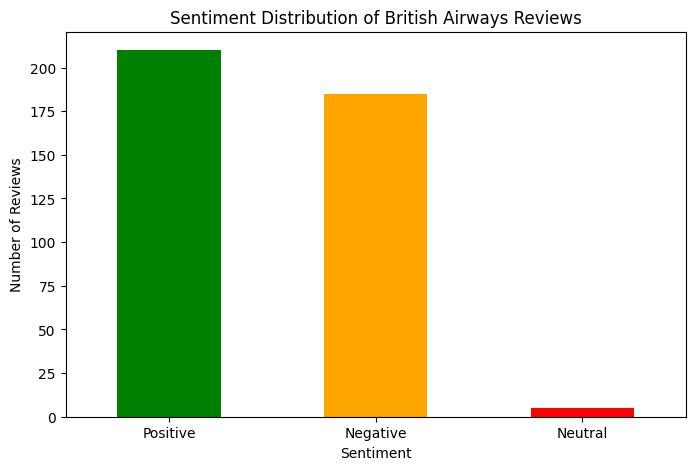

In [5]:
import matplotlib.pyplot as plt

# Plot the distribution of sentiments
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Sentiment Distribution of British Airways Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()


## Deeper Analysis
Carrying out a Deeper Analysis to find out which words and phrases are most common in the reviews from 2023-2024

Word Frequency Analysis
We'll split the dataset into positive and negative reviews, clean the text and then calculate the most frequent words. For better insights, we'll exclude common stopwords like "the", "and", "is" etc but to start we'll begin with two simple word clouds for both the positive and negative reviews 

First I'll begin by installing all the necessary libraries 

In [13]:
!pip install wordcloud
!pip install matplotlib

   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   -- ------------------------------------ 20.5/300.2 kB 162.5 kB/s eta 0:00:02
   --- ----------------------------------- 30.7/300.2 kB 262.6 kB/s eta 0:00:02
   ------- ------------------------------- 61.4/300.2 kB 328.2 kB/s eta 0:00:01
   ---------- ---------------------------- 81.9/300.2 kB 353.1 kB/s eta 0:00:01
   ------------ ------------------------- 102.4/300.2 kB 420.8 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/300.2 kB 364.4 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/300.2 kB 405.9 kB/s eta 0:00:01
   ----------------------- -------------- 184.3/300.2 kB 464.2 kB/s eta 0:00:01
   --------------------------- ---------- 215.0/300.2 kB 485.3 kB/s eta 0:00:01
   ------------------------------- ------ 245.8/300.2 kB 485.6 kB/s eta 0:00:01
   ----------------------------------- -- 276.5/300.2 kB 

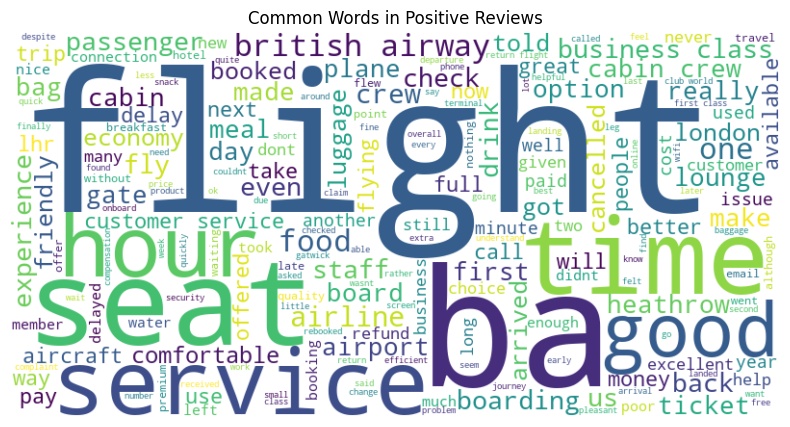

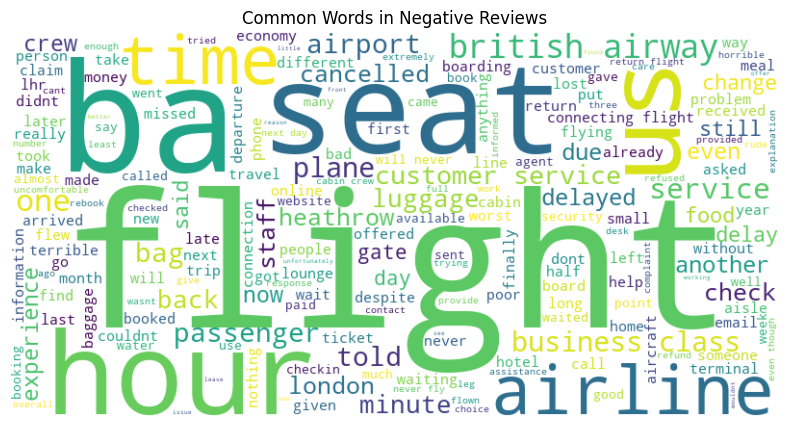

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset with sentiment analysis
df = pd.read_csv('data/british_airways_reviews_with_sentiment.csv')

# Combine all positive reviews into a single string
positive_text = ' '.join(df[df['sentiment'] == 'Positive']['content_clean'])

# Combine all negative reviews into a single string
negative_text = ' '.join(df[df['sentiment'] == 'Negative']['content_clean'])

# Generate word cloud for positive reviews
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Generate word cloud for negative reviews
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot the word cloud for positive reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Positive Reviews')
plt.show()

# Plot the word cloud for negative reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Negative Reviews')
plt.show()


Removing certain words off the word cloud to get a clearer picture of what people are talking about 

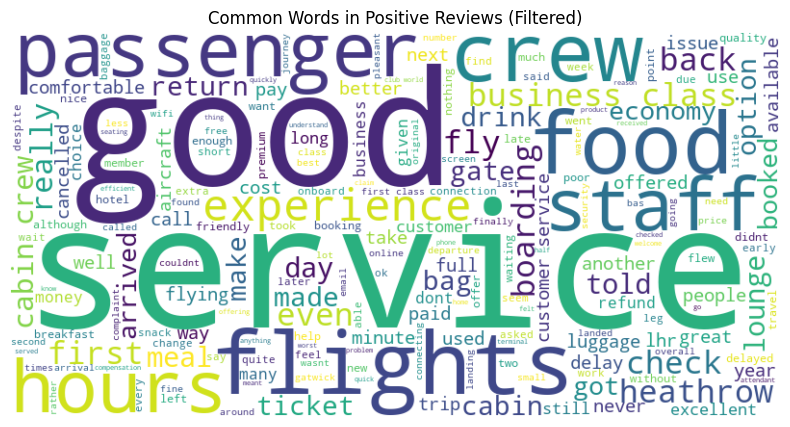

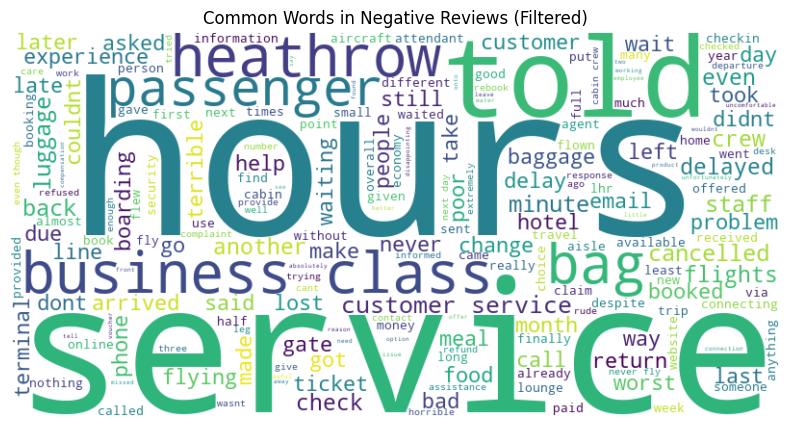

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords

# Load the dataset with sentiment analysis
df = pd.read_csv('data/british_airways_reviews_with_sentiment.csv')

# Define stopwords and add custom words that are not useful for analysis
stop_words = set(stopwords.words('english'))
custom_stopwords = {'flight', 'ba', 'british', 'airways', 'airline', 'plane', 'hour', 'will', 'london', 'airport', 'airlines', 
                    'board', 'us', 'seat', 'time', 'one', 'seats'}
stop_words.update(custom_stopwords)

# Function to clean text and remove unwanted words
def clean_text(text):
    words = text.split()
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

# Clean the positive and negative reviews by removing unnecessary words
df['content_clean_filtered'] = df['content_clean'].apply(clean_text)

# Combine all positive reviews into a single string
positive_text = ' '.join(df[df['sentiment'] == 'Positive']['content_clean_filtered'])

# Combine all negative reviews into a single string
negative_text = ' '.join(df[df['sentiment'] == 'Negative']['content_clean_filtered'])

# Generate word cloud for positive reviews
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Generate word cloud for negative reviews
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot the word cloud for positive reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Positive Reviews (Filtered)')
plt.show()

# Plot the word cloud for negative reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Negative Reviews (Filtered)')
plt.show()


In [9]:
!pip install spacy
!python -m spacy download en_core_web_sm

  Using cached spacy-3.7.6-cp311-cp311-win_amd64.whl.metadata (27 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.10-cp311-cp311-win_amd64.whl.metadata (2.0 kB)
  Using cached cymem-2.0.8-cp311-cp311-win_amd64.whl.metadata (8.6 kB)
  Using cached preshed-3.0.9-cp311-cp311-win_amd64.whl.metadata (2.2 kB)
  Using cached thinc-8.2.5-cp311-cp311-win_amd64.whl.metadata (15 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.4.8-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.12.5-py3-none-any.whl.metadata (15 kB)
  Using cached langcodes-3.4.1-py3-none-any.whl.metadata (29 kB)
  Using cached language_data-1.2.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached blis-0.7.11-cp311-cp311

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.0/12.8 MB 393.8 kB/s eta 0:00:33
     --------------------------------------- 0.1/12.8 MB 328.2 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 438.1 kB/s eta 0:00:30
     --------------------------------------- 0.1/12.8 MB 504.4 kB/s eta 0:00:26
     --------------------------------------- 0.1/12.8 MB 473.7 kB/s eta 0:00:27
      -------------------------------------- 0.2/12.8 MB 499.5 kB/s eta 0:00:26
      -------------------------------------- 0.2/12.8 MB 573.4 kB/s eta 0:00:22
      -------------------------------------- 0.3/12.8 MB 605.3 kB/s eta 0:00:21
      -------------------------------------- 0.3/12.8 MB 567.7 kB/s eta 0:00:23
      -------------------------------------- 0.3/12.8 MB

In [10]:
import spacy
from collections import Counter
import pandas as pd
import re
from spacy.util import filter_spans

# Load Spacy's English model
nlp = spacy.load('en_core_web_sm')

# Load the dataset with sentiment analysis
df = pd.read_csv('data/british_airways_reviews_with_sentiment.csv')

# Define custom stopwords to remove irrelevant terms
custom_stopwords = {'flight', 'ba', 'british', 'airways', 'airline', 'plane', 'hour', 'will'}

# Function to clean and tokenize text using Spacy
def clean_tokenize_spacy(text):
    # Remove special characters and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    doc = nlp(text)
    tokens = [token.text for token in doc if token.text not in custom_stopwords and not token.is_stop and not token.is_punct]
    return tokens

# Separate positive and negative reviews
positive_reviews = df[df['sentiment'] == 'Positive']['content_clean'].apply(clean_tokenize_spacy)
negative_reviews = df[df['sentiment'] == 'Negative']['content_clean'].apply(clean_tokenize_spacy)

# Flatten the list of tokenized words for positive and negative reviews
positive_words = [word for tokens in positive_reviews for word in tokens]
negative_words = [word for tokens in negative_reviews for word in tokens]

# For bigrams (two-word phrases)
positive_bigrams = list(zip(positive_words, positive_words[1:]))
negative_bigrams = list(zip(negative_words, negative_words[1:]))

# For trigrams (three-word phrases)
positive_trigrams = list(zip(positive_words, positive_words[1:], positive_words[2:]))
negative_trigrams = list(zip(negative_words, negative_words[1:], negative_words[2:]))

# Get the most common bigrams and trigrams
positive_bigram_freq = Counter(positive_bigrams).most_common(20)
negative_bigram_freq = Counter(negative_bigrams).most_common(20)
positive_trigram_freq = Counter(positive_trigrams).most_common(20)
negative_trigram_freq = Counter(negative_trigrams).most_common(20)

# Print the most common bigrams and trigrams in positive reviews
print("Most common bigrams in positive reviews:")
print(positive_bigram_freq)

print("\nMost common trigrams in positive reviews:")
print(positive_trigram_freq)

# Print the most common bigrams and trigrams in negative reviews
print("\nMost common bigrams in negative reviews:")
print(negative_bigram_freq)

print("\nMost common trigrams in negative reviews:")
print(negative_trigram_freq)


Most common bigrams in positive reviews:
[(('business', 'class'), 71), (('cabin', 'crew'), 58), (('customer', 'service'), 39), (('club', 'world'), 18), (('london', 'heathrow'), 17), (('premium', 'economy'), 14), (('club', 'europe'), 13), (('ground', 'staff'), 12), (('new', 'club'), 11), (('middle', 'seat'), 11), (('3', 'hours'), 10), (('food', 'drink'), 9), (('wo', 'nt'), 9), (('bottle', 'water'), 9), (('nt', 'care'), 9), (('food', 'good'), 8), (('2', 'hours'), 8), (('long', 'haul'), 8), (('inflight', 'entertainment'), 8), (('return', 'journey'), 8)]

Most common trigrams in positive reviews:
[(('business', 'class', 'seats'), 6), (('business', 'class', 'cabin'), 5), (('london', 'city', 'airport'), 4), (('new', 'club', 'world'), 4), (('fast', 'track', 'security'), 4), (('cabin', 'crew', 'excellent'), 4), (('cabin', 'crew', 'friendly'), 4), (('new', 'club', 'suites'), 4), (('delayed', '2', 'hours'), 3), (('booked', 'business', 'class'), 3), (('gold', 'card', 'holder'), 3), (('bas', 'cust

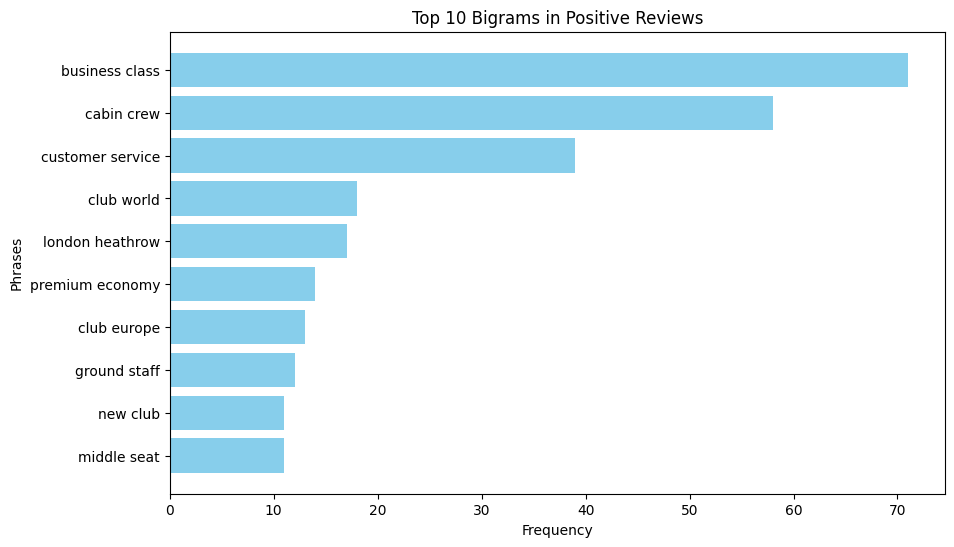

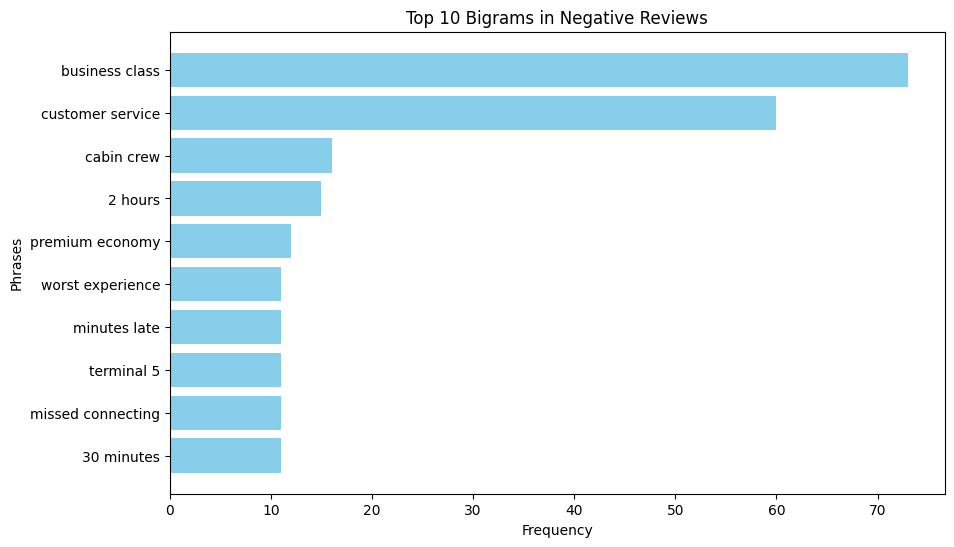

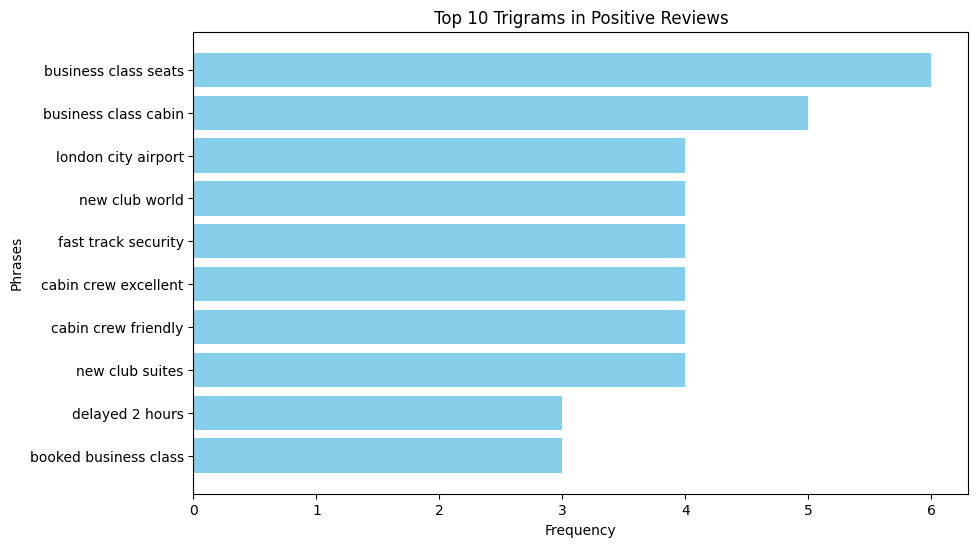

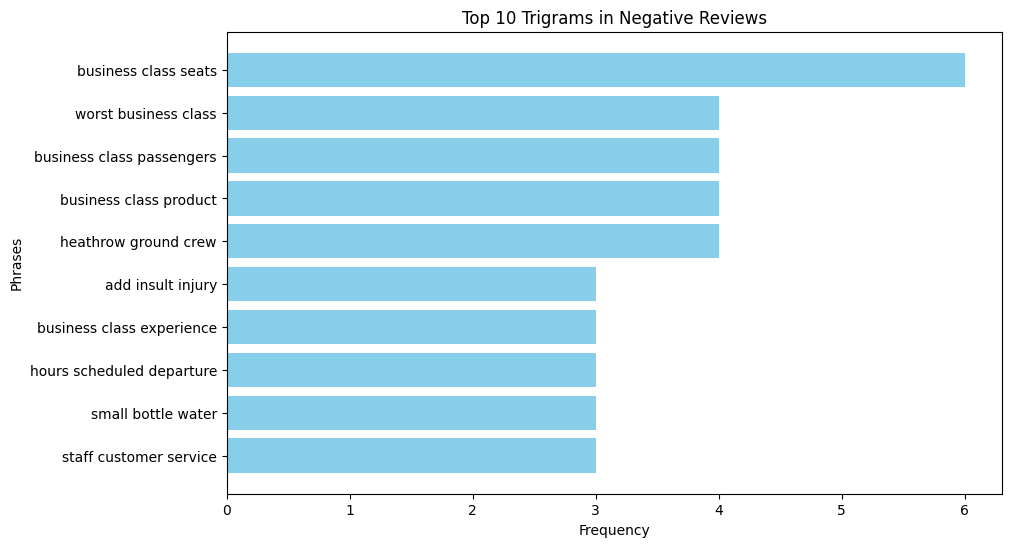

In [11]:
import matplotlib.pyplot as plt

# Function to plot top N bigrams/trigrams
def plot_phrases(phrases_freq, title, n=10):
    phrases, freq = zip(*phrases_freq[:n])  # Get top N phrases and their frequencies
    phrases = [' '.join(phrase) for phrase in phrases]  # Join tuples to form phrases
    
    plt.figure(figsize=(10, 6))
    plt.barh(phrases, freq, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Phrases')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to display the top phrase at the top
    plt.show()

# Plot top 10 bigrams in positive reviews
plot_phrases(positive_bigram_freq, 'Top 10 Bigrams in Positive Reviews')

# Plot top 10 bigrams in negative reviews
plot_phrases(negative_bigram_freq, 'Top 10 Bigrams in Negative Reviews')

# Plot top 10 trigrams in positive reviews
plot_phrases(positive_trigram_freq, 'Top 10 Trigrams in Positive Reviews')

# Plot top 10 trigrams in negative reviews
plot_phrases(negative_trigram_freq, 'Top 10 Trigrams in Negative Reviews')


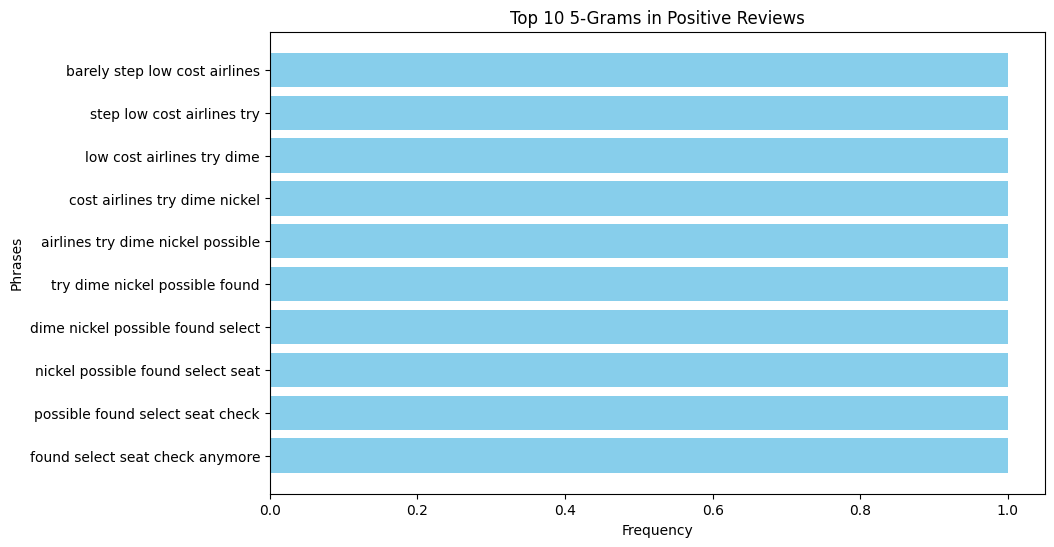

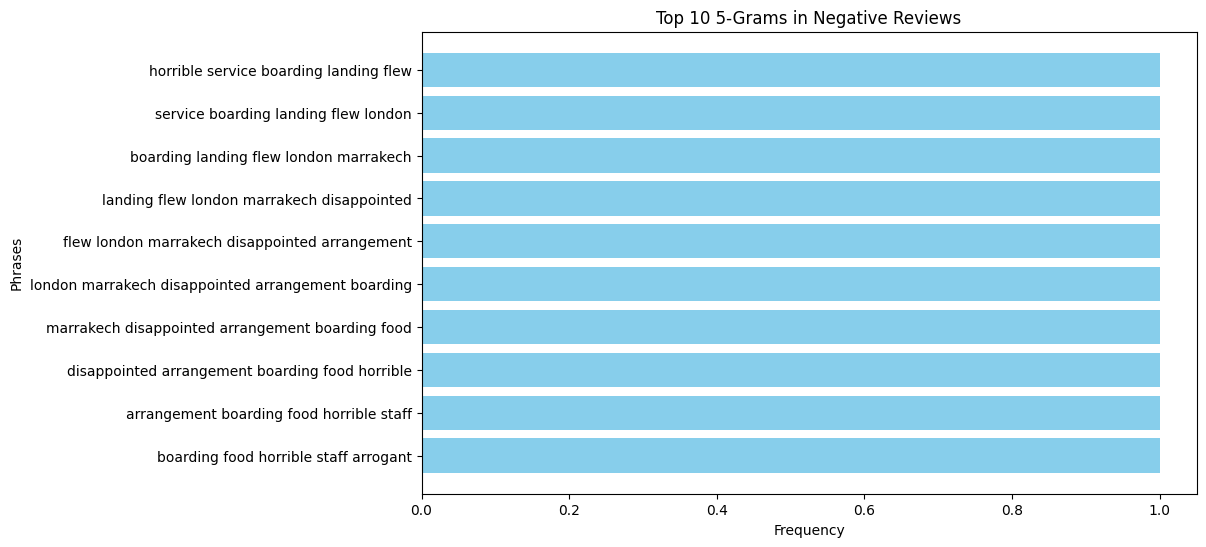

In [12]:
from collections import Counter
import matplotlib.pyplot as plt
from nltk import ngrams

# Function to clean and tokenize text using Spacy (same as before)
def clean_tokenize_spacy(text):
    # Remove special characters and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    doc = nlp(text)
    tokens = [token.text for token in doc if token.text not in custom_stopwords and not token.is_stop and not token.is_punct]
    return tokens

# Separate positive and negative reviews
positive_reviews = df[df['sentiment'] == 'Positive']['content_clean'].apply(clean_tokenize_spacy)
negative_reviews = df[df['sentiment'] == 'Negative']['content_clean'].apply(clean_tokenize_spacy)

# Flatten the list of tokenized words for positive and negative reviews
positive_words = [word for tokens in positive_reviews for word in tokens]
negative_words = [word for tokens in negative_reviews for word in tokens]

# For 5-grams (five-word phrases)
positive_5grams = list(ngrams(positive_words, 5))
negative_5grams = list(ngrams(negative_words, 5))

# Get the most common 5-grams
positive_5gram_freq = Counter(positive_5grams).most_common(20)
negative_5gram_freq = Counter(negative_5grams).most_common(20)

# Function to plot top N n-grams
def plot_phrases(phrases_freq, title, n=10):
    phrases, freq = zip(*phrases_freq[:n])  # Get top N phrases and their frequencies
    phrases = [' '.join(phrase) for phrase in phrases]  # Join tuples to form phrases
    
    plt.figure(figsize=(10, 6))
    plt.barh(phrases, freq, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Phrases')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to display the top phrase at the top
    plt.show()

# Plot top 10 5-grams in positive reviews
plot_phrases(positive_5gram_freq, 'Top 10 5-Grams in Positive Reviews')

# Plot top 10 5-grams in negative reviews
plot_phrases(negative_5gram_freq, 'Top 10 5-Grams in Negative Reviews')


Total reviews mentioning 'business class': 78
Positive reviews about business class: 43
Negative reviews about business class: 35


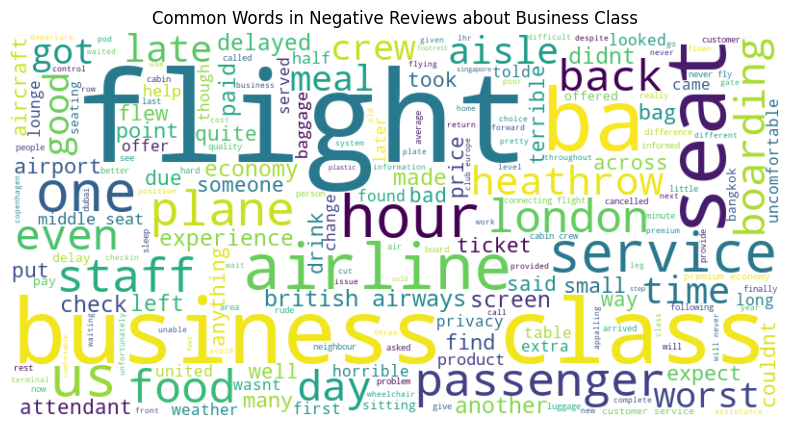


Sample Negative Reviews about Business Class:

horrible service from boarding to landing i flew from london to marrakech and was very disappointed with the arrangement for boarding my food is horrible the staff are arrogant to me and the seats are super uncomfortable for a 3h40min flight business class today taking the flight from marrakech to london i do not recommend
---
singapore to heathrow business class on an a380800 is a premium economy plus experience from the economy class sized toilets to the badly designed coffin shaped business class pods the experience is a substandard business class experience business class pods storage is a small drawer at the foot of the pod the privacy screens are opaque plastic sheets so you are kept awake by your neighbour as their screen lights up your pod when the seat is made into its coffin shaped bed the cold hard plastic seat moulds are an unpleasant surprise for those that turn in their sleep you have a choice of having your neighbour step o

In [13]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/british_airways_reviews_with_sentiment.csv')

# Filter reviews containing the phrase "business class"
df_business_class = df[df['content_clean'].str.contains('business class', case=False, na=False)]

# Separate positive and negative reviews about business class
positive_bc_reviews = df_business_class[df_business_class['sentiment'] == 'Positive']
negative_bc_reviews = df_business_class[df_business_class['sentiment'] == 'Negative']

# Show the number of positive and negative business class reviews
print(f"Total reviews mentioning 'business class': {len(df_business_class)}")
print(f"Positive reviews about business class: {len(positive_bc_reviews)}")
print(f"Negative reviews about business class: {len(negative_bc_reviews)}")

# Combine all negative reviews mentioning business class
negative_bc_text = ' '.join(negative_bc_reviews['content_clean'])

# Create a word cloud for negative business class reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_bc_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Negative Reviews about Business Class')
plt.show()

# Optionally, print a few negative reviews to manually inspect
print("\nSample Negative Reviews about Business Class:\n")
for review in negative_bc_reviews['content_clean'].head(5):
    print(review)
    print('---')


Filtered Word Cloud

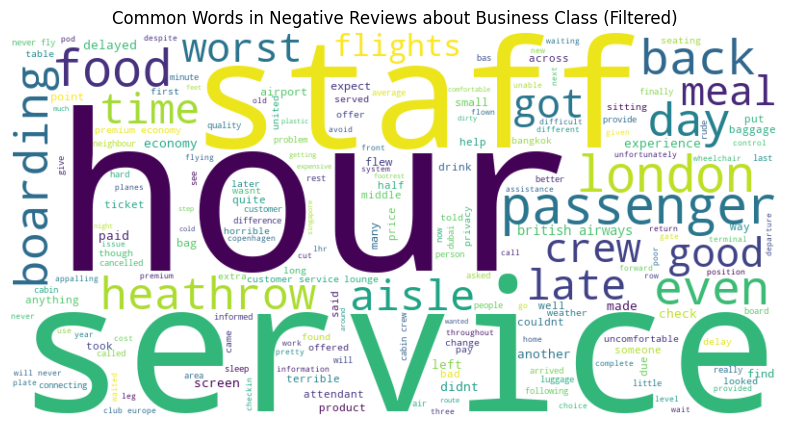

In [18]:
from wordcloud import STOPWORDS

# Define additional custom stopwords to remove irrelevant words
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['ba', 'flight', 'us', 'airline', 'business class', 'british airways', 'aircraft', 'seat', 'business',
                        'class', 'seats', 'one', 'plane', 'airlines'])

# Create a word cloud for negative business class reviews, excluding custom stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(negative_bc_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Negative Reviews about Business Class (Filtered)')
plt.show()


## Sentimental Distribution by Rating

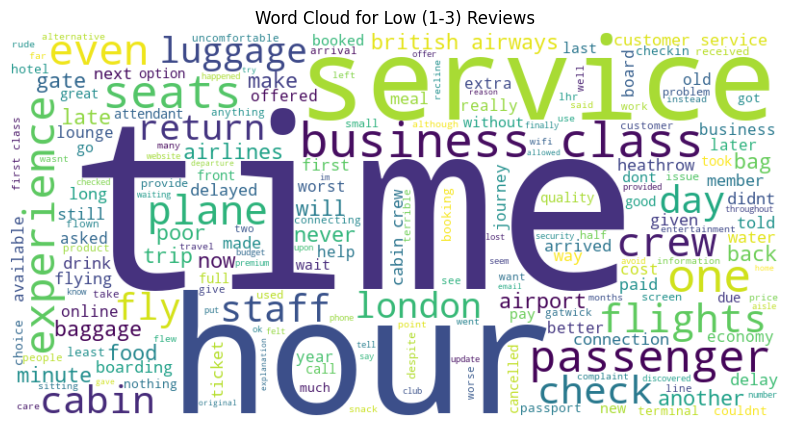

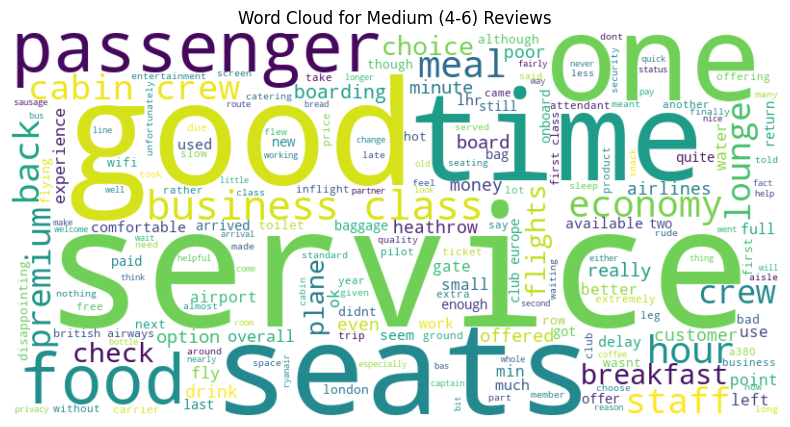

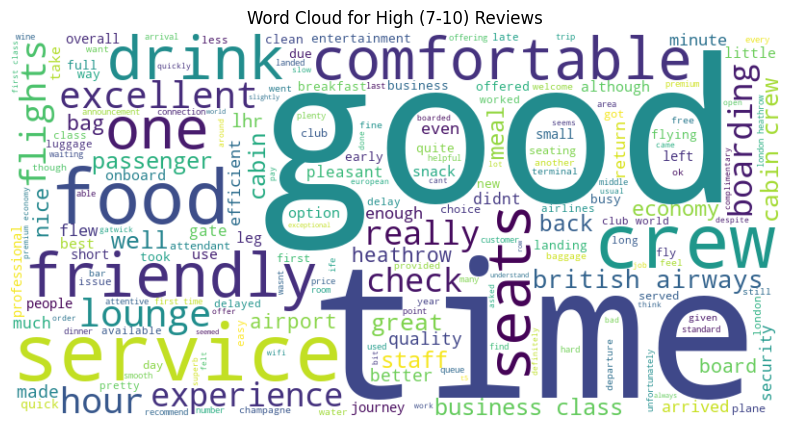

In [22]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset with the correct path
df = pd.read_csv('data/british_airways_reviews_with_sentiment.csv')

# Define custom stopwords to filter out words we don't need
custom_stopwords = set(WordCloud().stopwords)
custom_stopwords.update(['ba', 'flight', 'us', 'airline', 'business class', 'british airways', 'aircraft', 'seat'])

# Function to generate a word cloud for a specific rating group
def generate_wordcloud_for_group(group_name, df):
    # Filter reviews by the rating group
    reviews = df[df['rating_group'] == group_name]['content_clean']
    
    # Combine all reviews for the selected group
    text = ' '.join(reviews)
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {group_name} Reviews')
    plt.show()

# Group the ratings into three categories
rating_bins = [1, 3, 6, 10]
rating_labels = ['Low (1-3)', 'Medium (4-6)', 'High (7-10)']

# Add a new column for rating group
df['rating_group'] = pd.cut(df['rating'], bins=rating_bins, labels=rating_labels, right=True)

# Generate word clouds for each rating group
generate_wordcloud_for_group('Low (1-3)', df)
generate_wordcloud_for_group('Medium (4-6)', df)
generate_wordcloud_for_group('High (7-10)', df)
